### Import packages

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
import matplotlib.ticker as ticker
# from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.ticker as mticker

from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic

sys.path.append('../')
import functions as fn

## Function to run pease model

In [145]:
def Pease_Model_v2(event_df, wf=0.02, ta=35, poly_dir=145, Hi = 25 * units('cm'), show_plot = False):


    def convert_to_k(T):

        if T.units == 'degree_Celsius':
            T = T.to('degree_Kelvin')
        elif T.units == 'delta_degree_Celsius':
            print('T!! should not be delta deg C')
        return T


    def find_Qlu(Tw, sigma, eo):
        Tw = convert_to_k(Tw)
        qlu = sigma * eo * Tw**4
        return qlu.to('W/m2')


    def find_Qld(Ta, sigma, ea):
        Ta = convert_to_k(Ta)
        qld = sigma * ea * Ta**4
        return qld.to('W/m2')


    def find_Qs(Ta, Tw, rho_a, Cpa, Va):

        Ta = Ta.magnitude * units('delta_degree_Celsius')
        Tw = Tw.magnitude * units('delta_degree_Celsius')

        Ch = 2e-3 # sensible heat coefficient

        qs = rho_a * Ch * Cpa * Va * (Ta-Tw)

        return qs.to('W/m2')


    def open_Qld(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_strd_{event_year}_v7.nc') as ds_sw:
            down_longwave = ds_sw.strd.sel(time=event_df.time.values).values * units('W/m2')

        qld = (down_longwave) # longwave down

        return qld
    
    
    def open_Qr(event_df):
        # determine event year to open
        event_year = pd.to_datetime(event_df.time.values[-1]).year
        if pd.to_datetime(event_df.time.values[-1]).month == 12:
            event_year+=1

        # grab shortwave downward data
        with xr.open_dataset(f'../data/forcing/regional_daily_era_ssrd_{event_year}_v7.nc') as ds_sw:
            down_shortwave = ds_sw.ssrd.sel(time=event_df.time.values).values * units('W/m2')

        qr = (1-0.1)*(down_shortwave) # short wave radiation absorbed (10% albedo)

        return qr
    
    
    
    # wind component that extends polynya
#     wind_angle = (poly_dir+ta)*units('degree')
#     wind_comp = vectors.comp_along_theta(event_df['u10'].values, event_df['v10'].values, wind_angle)
#     wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')


    
    # observed wind speed and direction
    wind_speed = np.sqrt(event_df['u10'].values**2 + event_df['v10'].values**2) * units('m/s')
    wind_dir = vectors.vector_angle(event_df['u10'].values, event_df['v10'].values)
    
    # predicted ice speed and direction
    ice_speed = wf * wind_speed.to('km/day')
    ice_dir = wind_dir - (ta*units('degree'))
    
    # back to components
    ice_u = ice_speed * np.cos(ice_dir.to('radian').magnitude)
    ice_v = ice_speed * np.sin(ice_dir.to('radian').magnitude)
    
    # component of ice drift along polynya direction
    ice_comp_along_polynya = vectors.comp_along_theta(ice_u, ice_v, poly_dir*units('degree'))
    Vi = ice_comp_along_polynya
    
    # daily ice drift
#     Vi = wf * wind_comp*units('m/s').to('km/day')

    # air temperature
    Ta = event_df['t2m'].values * units('degC')

    # water temperature
    Tw = -1.8 * units('degC')

    # surface heat balance
    #-----------------------
    # define positive upward
    Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
#     Qld = -open_Qld(event_df)
    Qs = -find_Qs(Ta, Tw, cst['rho_a'], cst['Cp_a'], wind_speed)
    Qr = -open_Qr(event_df) # short wave radiation absorbed (5% albedo)

    Qnet = Qlu+Qld+Qs+Qr

    # heat flux to ice production rate
    #-----------------------------------
    Fi = (Qnet / (cst['L_i']*cst['rho_i'])).to('cm/day')
    
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(3,3))
        ax.plot(Qs, label='sensible')
        ax.axhline(Qlu, label='lw u', c='b')
        ax.plot(Qld, label='lw d')
        ax.plot(Qr, label='shortwave')
        ax.plot(Qnet, c='k', label='net')
        ax.legend()
        
        
        
    # iteratively solve for the length
    #---------------------------------
    Xp = np.array([0]) * units('m')

    for tt in range(len(event_df)):

        # current length
        X_curr = Xp[-1]

        # change in length
        dXdt = Vi[tt] - X_curr * Fi[tt] / Hi
        dX = dXdt * units('day')


        Xnew = X_curr + dX
        Xp = np.append(Xp, Xnew)


    X_num = Xp[1:].to('km')

    # solve for limiting width
    #---------------------------------
    X_max = (Vi * Hi / Fi).to('km')
    # time to reach 95% of limiting size
    t95 = (3 * Hi / Fi).to('day')
    
    if show_plot:
        fig, ax = plt.subplots(figsize=(8,3))
        ax.plot(event_df.time, np.cumsum(Vi.magnitude), marker='.', c='k', label='Fi=0')
        ax.plot(event_df.time, X_num.to('km'), label='iter')
        ax.plot(event_df.time, X_max.to('km'), label='limiting width')
        ax.bar(event_df.time, event_df.length_145max, color='lightgray', label='obs')
        plt.legend()

    X_zip = np.cumsum(Vi*units('day'))
    
    return X_num, X_max, t95, X_zip, Ta, Vi, wind_speed

In [3]:
# constants
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [4]:

# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


# polynya and regional stats

In [118]:
df = pd.read_csv('../data/compiled_stats.csv')

# df['esei'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')

df['i145'] = vectors.comp_along_theta(df['ui'], df['vi'], 145*units('degree')) * units('cm/s').to('km/day')
df['i165'] = vectors.comp_along_theta(df['ui'], df['vi'], 165*units('degree')) * units('cm/s').to('km/day')

df['ese10'] = 0.02*vectors.comp_along_theta(df['u10'], df['v10'], 180*units('degree'))* units('m/s').to('km/day')
# df['ese10'][df.year>=2016] = 1.3*df['ese10'][df.year>=2016]




df['si_km'] = df['si'] * units('cm/s').to('km/day')

df['e10'] = - df['u10']
# manually modify this for now since I set too strict of threshold

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
                     
    
vi = (df['ui'].values, df['vi'].values)
vw = (df['u10'].values, df['v10'].values)
vp = (df['up'].values, df['vp'].values )
                              
df['ta_wi'] = vectors.turning_angle(vw,vi).magnitude
df['ta_ip'] = vectors.turning_angle(vi,vp).magnitude
df['ta_wp'] = vectors.turning_angle(vw,vp).magnitude




# identify base period
dfb = df[df['2003_2023']]

dfr = df[df.year >= 2003]


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_11159/2666883459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_11159/2666883459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_11159/2666883459.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [562]:
def dir_conds(dff, cat):
    
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':   
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)

    elif cat == 'poly':
        dir_cond = (dff['centermass_direction_r'] > 280) & (dff['centermass_direction_r'] < 330)
        
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 6)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 10)

    return speed_cond


In [565]:
#===============
DF = dfr
#===============

shoulder = (DF['season_start_flag'] + DF['season_end_flag'])
shoulder = DF['season_start_flag']

# wind_comp = vectors.comp_along_theta(DF['u10'].values, DF['v10'].values, wind_angle)

# wind_event = dir_conds(DF, 'wind') & (DF.s10>6)

# wind_event = (DF.s10>0)
wind_event = (DF.s10>6) #& dir_conds(DF, 'wind')
# wind_event = dir_conds(DF, 'wind')
# wind_event = (DF.u10<0) & (DF.s10>6.5)

# wind_event = speed_conds(DF, 'wind') & (DF.u10<0)
# wind_event = speed_conds(DF, 'wind') & dir_conds(DF, 'wind')
# wind_event =(wind_comp>0)
#  speed_conds(DF, 'wind') & 

In [566]:
126/161

0.782608695652174

In [567]:
len(list(set(DF.sequence)))

161

In [568]:
len(list(set(DF[shoulder].sequence)))

5

In [569]:
161-129

32

In [570]:

# determine sequences to evaluate
# omit any that intersect with beginning/end of ice season
# and make sure strong wind occur for at least part of event

initial_cond = ((DF.sequence!=-999)&(shoulder==False))&wind_event
all_seqs = np.array(list(set(DF.sequence[initial_cond])))


# print(len(all_seqs))

evaluate = {}

all_days = np.array([])

for ss in all_seqs:
    
    # current event
    event = (DF.sequence==ss)
    
    M = pd.to_datetime(DF.time[event].values[0]).month 
    D = pd.to_datetime(DF.time[event].values[0]).day 
    
    # if first day of event has weak winds, omit
    if wind_event[event].values[0]==False:
        print(f'{ss}: weak winds to start, omit')
        
#     elif (M == 12)&(D<4):
#         print(f'{DF.time[event].values[0]}: too early, omit')

    # otherwise, proceed
    else:
        evaluate[ss] = {}
        evaluate[ss]['max_ll'] = 0
        evaluate[ss]['start'] = DF.time[event].values[0] # start time
        evaluate[ss]['si'] = np.where(DF.time == DF.time[event].values[0])[0][0] # start index
        
        day_before = pd.to_datetime(DF.time[event].values[0]) - timedelta(days=1)
        day2_before = pd.to_datetime(DF.time[event].values[0]) - timedelta(days=2)
        day3_before = pd.to_datetime(DF.time[event].values[0]) - timedelta(days=3)
        evaluate[ss]['dbi'] = np.where(pd.to_datetime(DF.time) == day_before)[0][0] # day before
        # cannot go 2 days before becuase data missing for some events (e.g. '2019-12-02')
#         evaluate[ss]['dbi2'] = np.where(pd.to_datetime(DF.time) == day2_before)[0][0] # day before
#         evaluate[ss]['dbi3'] = np.where(pd.to_datetime(DF.time) == day3_before)[0][0] # day before
        
        # only include days where wind event persists
        for ii in range(len(wind_event[event].values)):
            if wind_event[event].values[ii] == True:
                evaluate[ss]['max_ll'] = DF.event_day[event].values[ii] # maximum event day w/ cont. winds
                evaluate[ss]['end'] = DF.time[event].values[ii]         # end time
                evaluate[ss]['fi'] = np.where(DF.time == DF.time[event].values[ii])[0][0] # end index
            else:
                break

        all_days = np.append(all_days, evaluate[ss]['max_ll'])

(array([79., 19.,  9.,  8.,  6.,  3.,  1.,  1.,  2.,  2.]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <BarContainer object of 10 artists>)

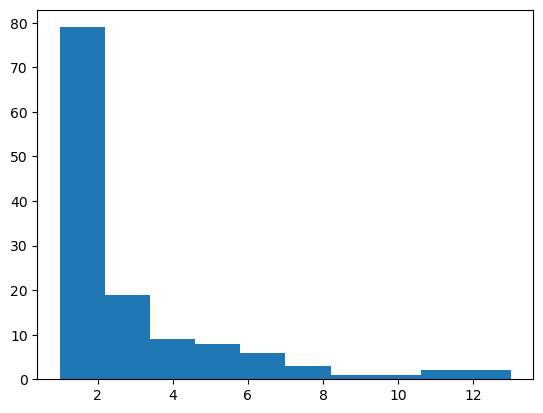

In [571]:
plt.hist(all_days)

### Set up dictionary to save data by day

In [572]:
across = {}

#========
lmax = 9
#========


cats = ['Fi=0', 'Xlim', 'Xp', 'Xo', 'seq', 'Ta', 'Vi', 'ws', 'date', 'cum_drift_real']

# across[f'-3'] = {}
# for cat in cats:
#     across[f'-3'][cat] = np.array([])
    
# across[f'-2'] = {}
# for cat in cats:
#     across[f'-2'][cat] = np.array([])
    
# across[f'-1'] = {}
# for cat in cats:
#     across[f'-1'][cat] = np.array([])

for ll in range(1, lmax+1):
    across[f'{ll}'] = {}
    for cat in cats:
        across[f'{ll}'][cat] = np.array([])

across[f'{lmax+1}+'] = {}
for cat in cats:
    across[f'{lmax+1}+'][cat] = np.array([])
    
    
    
    
# model params
#===============================
wf = 0.02 # wind factor
ta = 20   # CW turning angle wind to ice, degrees
poly_dir = 145  #  polynya direction, degrees CCW from E
Hi = 25 * units('cm')
#===============================
    
for ev in list(evaluate.keys()):
    
    # open data from event
    dbi = evaluate[ev]['dbi']
    si = evaluate[ev]['si']
    fi = evaluate[ev]['fi']

    # grab conditions over event
    #===============================
    event_df = DF[si:fi+1]
    #===============================
    
    

    # run model
    X_num, X_max, t95, X_zip, Tair, Vice, wsp = Pease_Model_v2(event_df, wf=wf, ta=ta, poly_dir=poly_dir, Hi = Hi, show_plot = False)
    
    # actual ice drift
    Vi_real = np.cumsum(event_df.i145.values) * units('km')
    
    # save output
    for ll, Xp, Xm, Xz, Xo, Ta, Vi, ws, date, count, Vir in zip(event_df.event_day.values, 
                                                           X_num, X_max, X_zip, event_df.length_145max.values,
                                   Tair, Vice, wsp, event_df.time.values, range(len(event_df.event_day.values)), Vi_real):

        # determine key to save to
#         if (ll == -999)&(count==0):
#             key = '-3'
#         elif (ll == -999)&(count==1):
#             key = '-2'
        if (ll == -999):
            key = '-1'
        elif ll > lmax:
            key = f'{lmax+1}+'
        else:
            key = f'{ll}'

        across[key]['Fi=0'] = np.append(across[key]['Fi=0'], Xz)
        across[key]['Xlim'] = np.append(across[key]['Xlim'], Xm)
        across[key]['Xp'] = np.append(across[key]['Xp'], Xp)
        across[key]['Xo'] = np.append(across[key]['Xo'], Xo*units('km'))
        
        across[key]['Ta'] = np.append(across[key]['Ta'], Ta)
        across[key]['Vi'] = np.append(across[key]['Vi'], Vi)
        across[key]['cum_drift_real'] = np.append(across[key]['cum_drift_real'], Vir)
        across[key]['ws'] = np.append(across[key]['ws'], ws)
        
        # record sequence number and date
        across[key]['seq'] = np.append(across[key]['seq'], int(event_df.sequence.values[-1]))
        across[key]['date'] = np.append(across[key]['date'], date)

        
for key in across.keys():
    across[key]['date'] = pd.to_datetime(across[key]['date'])

In [573]:
R = 0.9624271

In [574]:
# all_wp3 = all_wp

In [575]:
# all_wp2 = all_wp

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)


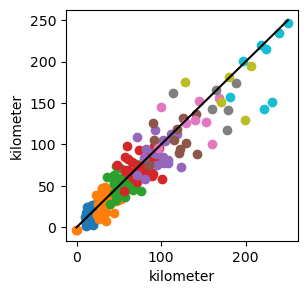

In [576]:
fig, ax = plt.subplots(figsize=(3,3))

all_wp = np.array([])
all_io = np.array([])

for key in across.keys():
    
    ax.scatter(across[key]['Fi=0'], across[key]['cum_drift_real'])
    
    all_wp = np.append(all_wp,across[key]['Fi=0'] )
    all_io = np.append(all_io,across[key]['cum_drift_real'] )
    
    
x = all_wp
y = all_io
result = stats.linregress(x, y)
print(result)
    
    
plt.plot([0,250], [0,250], c='k')


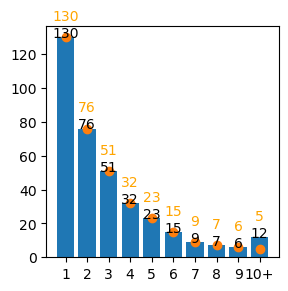

In [577]:
nums = np.array([len(across[ll]['Xlim']) for ll in across.keys()])
dnums = np.array([len(set(across[ll]['seq'])) for ll in across.keys()])

fig, ax = plt.subplots(figsize=(3,3))


ax.bar(across.keys(), nums)
ax.scatter(across.keys(), dnums)

for key, num, dnum in zip(across.keys(), nums, dnums):
    
    ax.text(key, num, num, ha='center')
    ax.text(key, num+10, dnum, ha='center', c='orange')

In [578]:
np.sum(nums[1:])

231

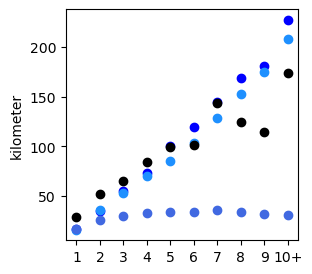

In [579]:
fig, ax = plt.subplots(figsize=(3,3))

for ll in across.keys():
    ax.scatter(ll, np.nanpercentile(across[ll]['Fi=0'], 50), c='b')
    ax.scatter(ll, np.nanpercentile(across[ll]['cum_drift_real'], 50), c='dodgerblue')
#     ax.scatter(ll, np.nanpercentile(across[ll]['Xlim'], 50), c='royalblue')
    ax.scatter(ll, np.nanpercentile(across[ll]['Xp'], 50), c='royalblue')
    
    ax.scatter(ll, np.nanpercentile(across[ll]['Xo'], 50), c='k')

### Grab percentiles over time

In [580]:
CATS = ['Fi=0', 'Xp', 'Xo', 'Xlim', 'Ta', 'ws', 'Vi',]#cum_drift_real
percentiles = [5,25,50,75,95]
byday = {}

for cat in CATS:
    byday[cat] = {}
    for per in percentiles:
        byday[cat][per] = np.array([])
    byday[cat]['mean'] = np.array([])
    byday[cat]['std'] = np.array([])

for cat in CATS:
    
    # grab all data
    all_data = np.array([])
    for ll in across.keys():
        all_data = np.append(all_data, across[ll][cat].magnitude)
        # save each percentile
        for per in percentiles:
            byday[cat][per] = np.append(byday[cat][per], np.nanpercentile(across[ll][cat].magnitude, per))
            
        byday[cat]['mean'] = np.append(byday[cat]['mean'], np.nanmean(across[ll][cat].magnitude))
        byday[cat]['std'] = np.append(byday[cat]['std'], np.nanstd(across[ll][cat].magnitude))

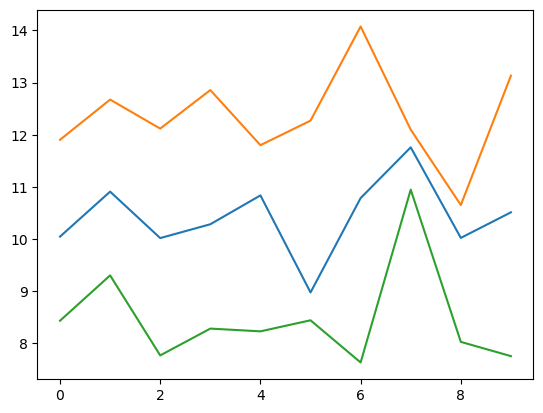

In [581]:
cat = 'ws'
plt.plot(byday[cat][50])
plt.plot(byday[cat][75])
plt.plot(byday[cat][25])

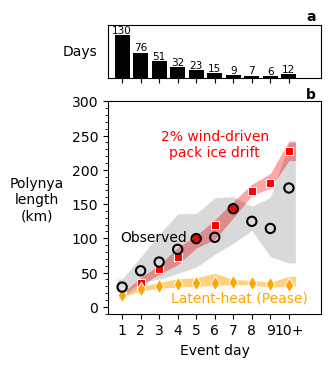

In [582]:
fig, axs = plt.subplots(2,1,figsize=(2.75,3.75), gridspec_kw={'height_ratios':[0.25,1]})
    

# for xx, cat, color, color2, fillc,lab, mr, zo, al, LW, S in zip([np.append(np.array([-1,0]),days), days, 
#                                         np.append(np.array([-1,0]),days),], ['wind', 'obs', 'lat'], 
#                               ['white', [0.3,0.3,0.3], 'white'][::-1], 
#                               [[75/255,150/255,255/255], 'None', 'orange'][::-1], 
#                                 [[75/255,150/255,255/255], 'k', 'orange'][::-1],                           
#                              ['Wind-driven ice drift', 'observed', 'Latent-heat estimate'],
#                                                ['d', 's', 'o'][::-1], [0,1,0], [0.4,0.15,0.4], [0.5,1.5,0.5],
#                                                           [60,40,60]):

x = np.arange(len(across.keys()))


ax = axs[0]
ax.set_ylim(0,160)
ax.bar(x, nums, color='k')
# ax.scatter(x, dnums)
ax.set_yticks([])
ax.set_ylabel('Days', rotation=0, labelpad=20, va='center')
for xx, num, dnum in zip(x, nums, dnums):
    ax.text(xx, num, num, ha='center', va='bottom', size=7.5)
#     ax.text(key, num+10, dnum, ha='center', c='orange')
    
    
# ax.set_xticks(x)
# ax.set_xticklabels([])
# ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
# ax.set_ylim(3,16)
# ax.set_ylabel('Wind\nspeed\n($\mathrm{m\;s^{-1}}$)', rotation=0, labelpad=25, va='center')
# cat = 'ws'

# for X, Ymin, Ymax in zip(x, byday[cat][25].magnitude, byday[cat][75].magnitude):
#     ax.plot([X,X], [Ymin, Ymax], lw=1, color='k', alpha=1, zorder=-10)
# ax.scatter(x, byday[cat][50], lw=0, color='k', alpha=1, zorder=-10)

# ax.fill_between(x, byday[cat][25], byday[cat][75], lw=0, color=fillc, alpha=alpha, zorder=-10)



# ax = axs[0]
ax.set_xticks(x)
ax.set_xticklabels([])
# ax.set_ylim(-25,-12)
# ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
# ax.set_ylabel('$\mathrm{T_{a}\;(^{\circ}C)}$', rotation=0, labelpad=20, va='center')
# cat = 'Ta'


# for X, Ymin, Ymax, Ymid, low, high in zip(x, byday[cat][25].magnitude, byday[cat][75].magnitude, 
#                                byday[cat][50].magnitude, byday[cat][5].magnitude, byday[cat][95].magnitude):
# #     ax.plot([X,X], [Ymin, Ymax], lw=1, color='k', alpha=1, zorder=-10)
    
#     bottom = Ymin
#     middle = Ymid
#     top = Ymax
#     height=(top-bottom)
#     bf = 0.2
#     rectangle = patches.Rectangle((X-bf, bottom), 2*bf, height, lw=1, edgecolor='k', facecolor='None', alpha=1)
#     ax.add_patch(rectangle)
#     ax.plot([X-bf,X+bf], [Ymid, Ymid], c='k', lw=2.25)
# #     ax.plot([X,X], [low,high], c='k', lw=1, zorder=-1)
    
# #     ax.plot([X-bf/2,X+bf/2], [low,low], c='k', lw=1, zorder=-1)
# #     ax.plot([X-bf/2,X+bf/2], [high,high], c='k', lw=1, zorder=-1)
    
# #     ax.scatter([X], [Ymid], c='k', lw=1, zorder=0)
    
#     bf = 0.1
#     ll = list(across.keys())[X]
#     ax.scatter(np.linspace(X-bf,X+bf, len(across[ll][cat])), across[ll][cat].magnitude, 
#                s = 1, zorder=-1, c='lightgray')
    
    
#     rectangle = patches.Rectangle((dd-bf, bottom), 2*bf, height, lw=LW, edgecolor=color, facecolor='None')
#     ax.add_patch(rectangle)
    
    
# for X, Ymin, Ymax in zip(x, byday[cat][5].magnitude, byday[cat][95].magnitude):
#     ax.plot([X,X], [Ymin, Ymax], lw=1, color='k', alpha=1, zorder=-10)
# ax.plot(x, byday[cat][50], lw=1.5, color='k', alpha=1, marker='o', zorder=-10)
# ax.fill_between(x, byday[cat][25], byday[cat][75], lw=0, color='k', alpha=0.15, zorder=-10)



ax = axs[1]

x_adj = np.concatenate((np.array([x.min()-0.25]), x, np.array([x.max()+0.35])))


color2 = [75/255,150/255,255/255]
color2 = 'orange'

color1 = 'r'

for cat, fillc, alpha, edgec, facec, xx, LW, mr, ms in zip(['Fi=0', 'Xp', 'Xo', 'cum_drift_real'], 
                                      [color1, color2, 'k'], 
                                                  [0.35,0.5,0.15],
                                     ['white', 'white', 'k'], 
                                                       
                                            [color1, color2, 'None'], 
                                      [x_adj,x_adj,x_adj], 
                                                       [0.75,0.75,1.5],
                                     [ 's','d', 'o'], [40,55,45]):

#     ax.fill_between(xx, np.concatenate((np.array([byday[cat][25][0].magnitude]), 
#                                         byday[cat][25].magnitude, np.array([byday[cat][25].magnitude[-1]]))), 
#                    np.concatenate((np.array([byday[cat][75][0].magnitude]), byday[cat][75].magnitude, np.array([byday[cat][75].magnitude[-1]]))), lw=0, color=fillc, alpha=alpha, zorder=-10)


    low = byday[cat][25]
    high = byday[cat][75]

#     low = (byday[cat]['mean'] - byday[cat]['std'])
#     high = (byday[cat]['mean'] + byday[cat]['std'])
    
    
    

    ax.fill_between(xx, np.concatenate((np.array([low[0]]), low, np.array([low[-1]]))), 
                   np.concatenate((np.array([high[0]]), high, np.array([high[-1]]))), lw=0, color=fillc, alpha=alpha, zorder=-10)


#     ax.fill_between(xx, byday[cat][5], byday[cat][95], lw=0, color=fillc, alpha=alpha, zorder=-10)
    
#     ax.fill_between(np.append(xx, xx[-1]+0.35), 
#                     np.append(byday[cat][25], byday[cat][25][-1]), 
#                     np.append(byday[cat][75], byday[cat][75][-1]), lw=0, color=fillc, alpha=al, zorder=-1)
    
#     ax.scatter(xx[1:-1], byday[cat][50], 
#                edgecolor=edgec, lw=LW,
#                facecolor = facec,marker=mr, s=ms)
    ax.scatter(xx[1:-1], byday[cat][50], 
               edgecolor=edgec, lw=LW,
               facecolor = facec,marker=mr, s=ms)
    
# for kk, key in enumerate(across.keys()):
    
#     group = 'Xo'
#     ax.scatter(np.full(len(across[key][group]), kk), across[key][group], s=1, zorder=-1, c='darkgray')
    
#     group = 'Fi=0'
#     ax.scatter(np.full(len(across[key][group]), kk), across[key][group], s=1, zorder=-1, c='lightcoral')
    
#     group = 'Xp'
#     ax.scatter(np.full(len(across[key][group]), kk), across[key][group], s=1, zorder=-1, c='gold')
    
    
# plt.legend()
#     for dd in days:
#         yy = grouplen[cat]['all'][dd]
#         ax.scatter(np.full(len(yy), dd), yy, c=color2, s=1, zorder=-1)


ax.set_xticks(x)
ax.set_xticklabels(across.keys())

# ax.bar(days, nums/2, bottom=250, color='k', clip_on=False)
# for dd, n in zip(days, nums):
#     ax.text(dd, 250+n/2, f'{n:.0f}', c='k', ha='center', va='bottom', clip_on=False)

ax.set_ylim(-10,300)
ax.set_ylabel('Polynya\nlength\n(km)\n', rotation=0, labelpad=25, va='center')
ax.set_xlabel('Event day')


ax.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

for ax, ch, yy in zip(axs, ['a', 'b', 'c'], [1.03,1.0]):
    ax.text(0.975,yy, ch, weight='bold',  ha='right', va='bottom', transform=ax.transAxes)

# plt.axhline(6.25, zorder=-1, ls='dashed', c='darkgray')

plt.text(5, 220, '2% wind-driven\npack ice drift', ha='center', c=color1)
plt.text(3.5, 95, 'Observed', ha='right', c='k')
plt.text(10, 8, 'Latent-heat (Pease)', ha='right', c=color2)

# plt.axhline(0,c='k', lw=0.5, zorder=-100)
for ax in axs:
    ax.set_xlim(-0.75,10.75)
# plt.axhline(6.25, c='darkgray', ls='dashed')
# plt.text(10, -5, 'SIC resolution', ha='right', c='gray')


plt.subplots_adjust(hspace=0.175)

# fig.savefig('../figures/results/dailyevent_time.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [585]:
(10*units('km/day').to('m/s'))/(6*units('m/s'))

<Quantity(0.0192901235, 'dimensionless')>

In [460]:
len(df[df.event_length>1])

485

In [411]:
len(df[df.event_length==1])

52

In [401]:
len(df[df.event_length==1])

52

In [406]:
len(df[df.event_length==2])/2

35.0

In [407]:
len(df[df.event_length==3])/3

22.0

In [408]:
len(df[df.event_length==4])/4

17.0

In [410]:
len(df[df.event_length==5])/5

13.0

In [412]:
df.event_length.max()


19

In [417]:
len(list(set(df.sequence[df.event_length > 7])))

14

In [419]:
len(list(set(df.sequence[df.event_length <=7])))

147

In [441]:
114/len(df.sequence[df.event_length > 7])

0.6589595375722543

In [440]:
np.sum(df.event_length>=12)

114

In [445]:
len(list(set(df.sequence[df.event_length >=13])))

4

In [437]:
15+16+16+19

66

In [ ]:
32

In [420]:
14/(147+14)

0.08695652173913043

In [414]:
485+52

537

(array([52., 70., 66., 68., 65., 36.,  7.,  8.,  0., 40., 11., 48.,  0.,
         0., 15., 32.,  0.,  0., 19.]),
 array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 <BarContainer object of 19 artists>)

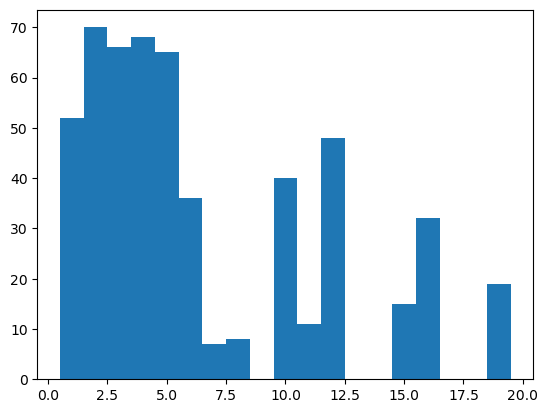

In [399]:
plt.hist(df.event_length[df.event_length!=-999], bins=np.arange(0.5,20,1))

In [ ]:
DF[DF.sequence==143]

In [ ]:
np.nanmean((byday['Fi=0'][50] - byday['Xo'][50])[1:6])

In [ ]:
byday['Fi=0'][50]

In [31]:
byday['Xp'][50]

Magnitude,[12.666136871337889 22.964408135258324 28.71123099819811 31.385671934641202 34.402958331508785 36.098796259077574 35.13606795679138 36.00880476540002 35.90649192964055 34.47313965726 32.00304483247725]
Units,kilometer


In [32]:
byday['Xo'][50]

Magnitude,[0.0 29.38230774473309 56.16063984482522 60.5611070357171 79.95132803397414 106.35674559620142 89.83480800558536 125.25848428058617 125.25300670626493 120.84748280798031 186.1209779332669]
Units,kilometer


In [28]:
np.nanmean(np.diff(byday['Fi=0'][50]))

<Quantity(22.9744191, 'kilometer')>

In [1610]:
across

{'-1': {'Fi=0': <Quantity([  6.24620627  16.0658454   16.89594873  14.31829742  10.11426691
    18.98737756  20.4451485   19.44458624  13.24888467  13.0502005
    15.98564301  24.18101971  13.38313568  12.03375284  16.80362238
    23.4310611   13.17827005  14.28887988   9.71023013  13.21223181
    14.54962006   6.72388783  10.03650595   2.45901235  16.3451283
    13.26127643  13.39675104   2.83765711   5.58626193  18.32751068
    11.95066489   3.95956343   0.82454207  12.38496872   1.42055149
    16.4880813   22.74067914   8.76882925  17.44116943   5.38832098
    22.38002216  18.73464972  12.12834512  20.93801056   9.42127872
    11.43118103 -10.04467731  15.59487305  14.97976611  16.10221893
    -5.14666901  24.50657703  10.37336819  21.45516504  22.07857104
    10.03807974  16.60582397   3.2279743   20.60851465   5.69108881
    14.09597589   9.08860391   8.45263477  18.34509924  18.55767151
    20.77381384   6.45012556  14.93218817  15.29384381  11.61060562
    16.66617352   7.975150

In [1573]:
np.sqrt(np.nanmean((DF.length_145max[DF.extent>0] - DF.length_max[DF.extent>0])**2))

3.262069738881133

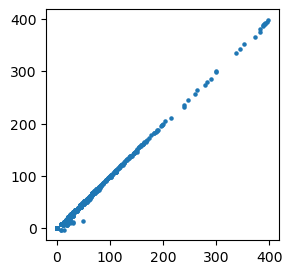

In [1520]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(DF.length_max, DF.length_145max, s=5)

In [1349]:
byday['Fi=0'][50]

Magnitude,[2.7978342132568352 8.563938903808594 20.022065654754634 36.41611764907836 58.09336125183105 80.4036813354492 95.38582039260864 125.33721514892578 144.53754184341432 163.69881790924072 193.43954862213133 211.6703889541626 237.5309829597473]
Units,kilometer


In [ ]:
byday['Fi=0'][50]

In [1271]:
cat

'Xo'

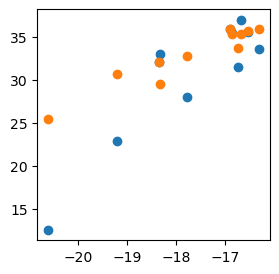

In [1272]:
fig, ax = plt.subplots(figsize=(3,3))
plt.scatter(byday['Ta'][50].magnitude, byday['Xp'][50].magnitude)
plt.scatter(byday['Ta'][50].magnitude, byday['Xlim'][50].magnitude)

## SIC maps

In [485]:
RES = '6250'
crop=[700, 1150, 200, 400]
sic_key = 'sic'
open_thresh = 10

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


out = unisic.calc_meansic_openfreq([datetime(2024,1,1), datetime(2024,1,2)], crop=crop, 
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)

In [486]:
across.keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+'])

In [487]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

RES = '6250'
# crop=[500, 1300, 100, 500]
crop=[700, 1150, 200, 400]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)

dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', 
                              main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

open_thresh=10

map_sic = {}

for key in across.keys():

    print(key)
    map_sic[key] = unisic.calc_meansic_openfreq(pd.to_datetime(across[key]['date']), crop=crop, nan_frac = 0.05,
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)


1
2
3
4
5
6
7
8
9
10+


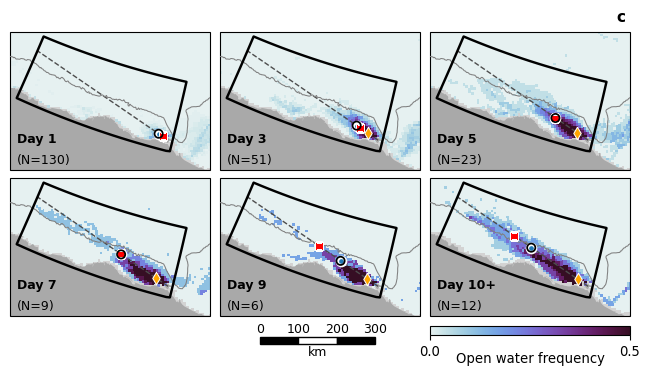

In [489]:
fig, axs = fn.makemap(view='wider_zoom3', contours = [-100], 
                      panels=(2,3), figsize=(8,3.75))
plt.subplots_adjust(hspace=0.025, wspace=0.05)


from pyproj import Geod
g = Geod(ellps='WGS84')
# startlon, startlat = -139, 69.5
startlon, startlat = -139.1, 69.6
# dists = np.array([31,64,79, 101,117,134,144,150])+10
# iced = np.array([50.82842169,  68.58080734,  90.47338417,
#         98.24958483, 120.57204264, 128.47181612])
wind = np.array([35.50381821,  75.51196037, 125.48660916, 171.30080786,
       205.45987047, 226.16189264])
latt = np.array([29.89207331, 32.11730528, 33.0155933 , 35.32942831, 28.70799943,
       30.70865801])
obss = np.array([29.38230774,  68.75966641, 106.3567456 , 143.28681747,
       114.46666782, 118.17654774])


bearing = -55

FS = 10

# wind = np.array([29.67029984, 81.62365485, 159.8473894, 174.82151541])
# latt = np.array([29.93782605, 33.22366475,  35.32942831, 33.74427032])
# obss = np.array([29.38230774, 76.14685572, 107.23015109, 83.90562419])

# for key, n, N in zip(['Dec', 'Jan', 'Feb', 'Mar',],
#                      [0,2,4,6], [1,3,5,7]):

FS = 9
for key, n in zip([f'{m}' for m in [1,3,5,7,9]]+[f'10+'],
                     range(6)):

#     axs[n].text(0.95,0.95,f'{chr(97+n+1)}', weight='bold', 
#                 ha='right', va='top', size=FS, transform=axs[n].transAxes)
    
    ax = axs[n]
    
    ax.add_geometries ([reg_poly], lw=1.75, edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())
    
    ax.text(0.035,0.175,f'Day {key}', weight='bold', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    ax.text(0.035,0.025,f'(N={len(across[key]['date'])})', ha='left', va='bottom', transform=ax.transAxes, size=FS)
    
    mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     mesh = ax.contourf(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#           vmin=0, vmax=0.5, levels = np.arange(0,0.5,0.05), extend='max', cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     mesh = ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#               vmin=0, vmax=0.6, cmap=cmocean.cm.dense, transform=dsic['proj'])
    
#     ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
#                   levels=[0.25, 0.5, 0.75], colors=['gold'], linewidths=[0.5,], transform=dsic['proj'])
    
    # dashed line
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, 400*1000)
    ax.plot([startlon,endlon], [startlat,endlat], transform=ccrs.PlateCarree(), 
            c=[0.3,0.3,0.3], lw=1, zorder=98, ls='dashed')
    
    
    
    
    for cat, fc, ec, marker, ms, lw in zip(['Xp', 'Fi=0', 'Xo'], 
                                       [color2, color1, 'None'], 
                                       ['white', 'white', 'k'], 
                                       ['d', 's', 'o'], [40, 30, 35], [0.75,0.75,1.25]):
    
        distance = np.nanpercentile(across[key][cat], 50).to('m').magnitude
    
        endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
        ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
                   s=ms, marker=marker, facecolor=fc, edgecolor=ec,lw=lw, zorder=102)
        
    distance = np.nanpercentile(across[key]['Xo'], 50).to('m').magnitude
    endlon, endlat, backaz = g.fwd(startlon, startlat, -55, distance)
    ax.scatter(endlon, endlat, transform=ccrs.PlateCarree(), 
               s=ms, marker=marker, facecolor=None, edgecolor='white',lw=2.5, zorder=101)
    
axs[2].text(0.975,1.05, f'c', weight='bold', 
                ha='right', va='bottom', size=FS+2, transform=axs[2].transAxes)
    
plotter.add_colorbar(fig, axs[-1], [mesh], cb_placement='bottom', cb_orientation='auto', 
                     cb_width=0.025, cb_length_fraction=[0, 1], cb_pad=0.025, cb_ticks=[0,0.5], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Open water frequency', labelpad=-5, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=FS+0.5, draw_edges=False, edge_params=['k', 2])

geomap.scalebar(axs[-2], loc=(0.2, -0.2), steps=[100,200,300],unit='km', 
                label=None, colors=['k', 'w'], edgecolor=None, textsize=FS, lw=1, 
                bar_width=0.05, labelpad=0.015, ticklabelpad=0.01, zorder=100, clip_on=False)

fig.savefig('../figures/results/dailyevent_maps.png', dpi=400, bbox_inches='tight', pad_inches=0)


In [1277]:
os.path()

TypeError: 'module' object is not callable

In [1303]:

main_path = '/Volumes/Seagate_Jewell/KenzieStuff/SIDEx_animation/filenames/'
new_folder = 'to_delete'

folders = os.listdir(main_path)

for folder in folders:
    
    if folder not in ['to_delete', '.DS_Store']:
    
        files = os.listdir(main_path+folder)

        for file in files:
            if '_v0.png' in file:

                try:
                    shutil.move(main_path+folder+'/'+file, main_path+new_folder+'/'+file)

                except FileNotFoundError:
                    print(f"Error: File '{file}' not found in '{folder}'.")
                except Exception as e:
                    print(f"An error occurred: {e}")



In [1301]:
main_path+folder+'/'+file

'/Volumes/Seagate_Jewell/KenzieStuff/SIDEx_animation/filenames/to_delete/VNP02MOD.A2021121.2024_v1.png'

In [1302]:
main_path+new_folder+'/'+file

'/Volumes/Seagate_Jewell/KenzieStuff/SIDEx_animation/filenames/to_delete//VNP02MOD.A2021121.2024_v1.png'

In [1296]:
main_path+folder+file

'/Volumes/Seagate_Jewell/KenzieStuff/SIDEx_animation/filenames/to_deleteVNP02MOD.A2021121.2024_v1.png'

In [1292]:
import shutil

In [1280]:
glob.glob('/Volumes/Seagate_Jewell/KenzieStuff/SIDEx_animation/filenames/2021060/')

['/Volumes/Seagate_Jewell/KenzieStuff/SIDEx_animation/filenames/2021060/']

In [ ]:
import shutil
import os

source_folder = "path/to/source_folder"
destination_folder = "path/to/destination_folder"
file_name = "your_file.png"

source_path = os.path.join(source_folder, file_name)
destination_path = os.path.join(destination_folder, file_name)

try:
    shutil.move(source_path, destination_path)
    print(f"File '{file_name}' moved successfully from '{source_folder}' to '{destination_folder}'.")
except FileNotFoundError:
    print(f"Error: File '{file_name}' not found in '{source_folder}'.")
except Exception as e:
    print(f"An error occurred: {e}")